# MASTER Unit 9 - Graph Algorithms at Scale
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2022`__

In this week's async you were introduced to a range of real life datasets whose underlying structure is best described as a graph. In class today we'll review common types of analysis to perform on graphs and key considerations for parallelizing these algorithms. We'll particularly focus on the 'Single Source Shortest Path' task using some toy graphs and a network derived from the `nltk` synonym database. By the end of the next two sessions, you will be able to:  

* ... __identify__ whether a dataset in row/column form can be interpreted as a graph.
* ... __choose__ a data structure to efficiently represent graphs for the purpose of parallel computaion.
* ... __recognize__ whether a problem lends itself to a path planning solution.  
* ... __describe__ the difference between BFS and DFS in terms of time and space complexity.
* ... __explain__ why dijkstra's algorithm is not embarassingly paralellizable.  
* ... __interpret__ the meaning of graph centrality metrics in the context of a specific problem or datset. (e.g. _the connection between eigenvector centrality and PageRank; bipartite graphs & recommender systems_.)

### Notebook Set-Up


[NetworkX](https://networkx.org/documentation/stable/tutorial.html) is a Python library for studying graphs and networks.

* Creating a graph
* A stochastic graph generator
* Drawing graphs
* The structure of a graph G can be analyzed using various graph-theoretic functions
  *  nx.connected_components(G)
  * all_pairs_shortest_path
  
  
``` python
sp = dict(nx.all_pairs_shortest_path(G))
sp[3]
{3: [3], 1: [3, 1], 2: [3, 1, 2]}
```

In [3]:
# imports
import re
import heapq
import itertools
import numpy as np
import networkx as nx # 
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 1. Graphs Overview

As you know from this week's async, graphs are ubiquitous in modern society and comprise an increasing proportion of big data problems. Your reading from chapter 5 of Lin & Dyer mentioned examples of graphs encountered by almost everyone on a daily basis include: the hyperlink structure of the web (simply known as the web graph), social networks (manifest in the flow of email, phone call patterns, connections on social networking sites, etc.), transportation networks (roads, bus routes, flights, etc.) and metabolic and regulatory network, which can be characterized as a large, complex graph involving interactions between genes, proteins, and other cellular products. 

Depending on the nature of the nodes and edges, there are different kinds of questions we might want to ask. Here's a list of six of the most common types of graph analyses (_we'll be focusing on the first three over the course of the next few weeks_):

__Graph Search & Path Planning:__ Search algorithms on graphs are invoked millions of times a day, whenever anyone searches for travel directions on the web. Similar algorithms are also involved in friend recommendations and expert-finding in social networks. Path planning problems involving everything from network packets to delivery trucks represent another large class of graph search problems.   
>`Additional Reference`: Dong C. Liu, Jorge Nocedal, Dong C. Liu, and Jorge Nocedal. On the limited memory BFGS method for large scale optimization. Mathematical Programming B, 45(3):503{528, 1989.  
  

__Identifying Special Nodes (Centrality):__ There are many ways to define what 'special' means, including metrics based on node in-degree, average distance to other nodes, and relationship to cluster structure. These special nodes are important to investigators attempting to break up terrorist cells, epidemiologists modeling the spread of diseases, advertisers trying to promote products, and many others. For example, eigenvector centrality is used to find popular webpages using the PageRank algorithm, which in turn has been extended to Text summarization, Keyword extraction/Concept extraction using TextRank.
> `Additional Reference`: An Overview of Graph-Based Keyword Extraction Methods and Approaches Slobodan Beliga, Ana Meštrović, Sanda Martinčić-Ipšić. Journal of Information and Organizational Sciences; Vol 39, No 1 (2015)

- A) Betweenness centrality 
- B) Closeness centrality 
- C) Eigenvector centrality 
- D) Degree centrality 
- E) Harmonic Centrality 
- F) Katz centrality of the same graph

__Graph Algorithms, Practical Examples in Apache Spark and Neo4j by Mark Needham and Amy E. Hodler__

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/centrality-fig5.1.png' style="width:100%;">

__Bipartite graph matching (Recommender systems):__ A bipartite graph is one whose vertices can be divided into two disjoint sets. Matching problems on such graphs can be used to model job seekers looking for employment or singles looking for dates.  
> `Additional Reference`: Computability, Complexity, and Algorithms; Charles Brubaker and Lance Fortnow https://s3.amazonaws.com/content.udacity-data.com/courses/gt-cs6505/bipartitematching.html  
> `Additional Reference`: Chapter 9 - Bipartite Graph Analysis Fouss, F., Saerens, M., & Shimbo, M. (2016). Bipartite Graph Analysis. In Algorithms and Models for Network Data and Link Analysis (pp. 390-436). Cambridge: Cambridge University Press. doi:10.1017/CBO9781316418321.010 https://www.cambridge.org/core/books/algorithms-and-models-for-network-data-and-link-analysis/bipartite-graph-analysis/270C999701532CEE15D5FE20412A2449

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/CompleteBipartiteGraph_1000.gif' style="width:50%;">

__Graph clustering:__ Can a large graph be divided into components that are relatively disjoint (for example, as measured by inter-component links? Among other applications, this task is useful for identifying communities in social networks (of interest to sociologists who wish to understand how human relationships form and evolve) and for partitioning large graphs (of interest to computer scientists who seek to better parallelize graph processing).    
> `For a survery, see`: Rui Xu and Donald Wunsch II. Survey of clustering algorithms. IEEE Transactions
on Neural Networks, 16(3):645{678, 2005.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/facebook-network.png' style="width:75%;">

__Minimum spanning trees:__ A minimum spanning tree for a graph G with weighted edges is a tree that contains all vertices of the graph and a subset of edges that minimizes the sum of edge weights. A real-world example of this problem is a telecommunications company that wishes to lay optical ber to span a number of destinations at the lowest possible cost (where weights denote costs). This approach has also been applied to wide variety of problems, including social networks and the migration of Polynesian islanders.

_http://www.martinbroadhurst.com/prims-minimum-spanning-tree-mst-algorithm-in-c.html_
<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/mst.png' style="width:50%;">

__Maximum Flow:__ In a weighted directed graph with two special nodes called the source and the sink, the max flow problem involves computing the amount of "traffic" that can be sent from source to sink given various flow capacities defined by edge weights. Transportation companies (airlines, shipping, etc.) and network operators grapple with complex versions of these problems on a daily basis.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/ford_fulkerson2.png' style="width:75%;">

_https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/_

# Warm-up questions:

> __DISCUSSION QUESTION:__ Brainstorm a few other examples of data with an underlying graph structure. 
For one of the examples you come up with...   
__a)__ _what are the nodes & edges?_   
__b)__ _is the graph __weighted/unweighted__? __directed/undirected__? __acyclic__? __connected__?_   
__c)__ _what is a problem/question that could be addressed by one of the 6 types of analysis above?_

# Exercise 2. Data Structures Review.

This lecture is focused on working with graphs in the context of MapReduce style design. One of the main challenges to "dividing and conquering" computations involving graphs is that the fundamental units of analysis (nodes and edges) carry information about each other so it often takes some careful planning to making sure that the appropriate information is co-located for the calculations we need to perform. Let's briefly review a few key data structures that will be of help. Note that these data structures are not unique to graph algorithms, though they will be particularly helpful for SSSP and PageRank.

__LIFO vs FIFO vs Priority queues__  
A queue is a data structure like a list with the added property of an expected order in which elements are added or removed. In most applications that ordering will be 'last in first out' (LIFO) or 'first in first out' (FIFO). The python double ended queue type `deque` ([docs](https://docs.python.org/3/library/collections.html), [pymotw tutorial](https://pymotw.com/3/collections/deque.html)) is a convenient way to implement either a FIFO or LIFO queue. In contrast, a priority queue maintains a sorted order based on the values of the contents of the sequence so that removing an element will always retrieve the highest/lowest. We usually implement a priority queue in python using `heapq` ([docs](https://docs.python.org/3.0/library/heapq.html), [pymotw tutorial](https://pymotw.com/2/heapq/)).

__Adjacency Matrix vs Adjacency List__  
Adjacency Matrices and Lists are the most common ways to encode a graph. In each, the rows represent nodes and the contents represent edges. In fact, you are already familiar with these data structures from HW3... the co-occurance matrix was a type of adjacency matrix (where we used `1`s and `0`s to encode a connection between two words); similarly the stripes were a form of adjacency list (where instead of storing`0`s for pairs of words that didn't have the connection of being neighbors we just listed the neighbors for each node). Here's a toy graph and its adjacency list representation to refresh your memory:

In [1]:
# a graph is a list of nodes and edges (RUN CELL AS IS)
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1), 
         ('A', 'E', 5), 
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}

In [21]:
# retrieving the adjacency list, 
# NOTE that we are discarding edge weights in the process of encoding
# but could add the weights to the adjacency list
# (RUN CELL AS IS)

def get_adj_graph_from_edges_list(TOY_GRAPH):
    ADJ_GRAPH = {} #unweighted
    for node in TOY_GRAPH['nodes']:
        if node not in ADJ_GRAPH:
            ADJ_GRAPH[node] = []

        for edge in TOY_GRAPH['edges']:
            if edge[0] == node:
                ADJ_GRAPH[node].append(edge[1])
    return ADJ_GRAPH
            
# a graph is a list of nodes and edges (RUN CELL AS IS)
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1), 
         ('A', 'E', 5), 
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}

print("Graph as adjecency list") # the neighbors       
print(get_adj_graph_from_edges_list(TOY_GRAPH))

Graph as adjecency list
{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}


> __DISCUSSION QUESTION:__ In the context of a MapReduce framework, would adjacency matrices or adjacency lists be a better way to represent a graph? Why?

# Exercise 3. Graph Traversal.

For many of the common graph problems introduced in exercise 1 we'll need to systematically visit the nodes in a graph in some kind of order. The idea of "ordering" the nodes in a graph is a little different than "ordering" data in a traditional row/column format. Sometimes a node might be associated with a particular label or value, in which case we might use a sorting strategy just like regular data. However often we'll want to instead use the graph's underlying structure to sequentially examine nodes based on their location. There are two basic ways to do this: breadth-first (BFS) and depth-first (DFS).

## Depth-First Search
__An analogy__   
An analogy you might think about in relation to depth-first search is a maze. The
maze—perhaps one of the people-size ones made of hedges, popular in England—
consists of narrow passages (think of edges) and intersections where passages meet
(vertices).
Suppose that someone is lost in the maze. She knows there’s an exit and plans to
traverse the maze systematically to find it. Fortunately, she has a ball of string and a
marker pen. She starts at some intersection and goes down a randomly chosen
passage, unreeling the string. At the next intersection, she goes down another
randomly chosen passage, and so on, until finally she reaches a dead end.
At the dead end she retraces her path, reeling in the string, until she reaches the
previous intersection. Here she marks the path she’s been down so she won’t take it
again, and tries another path. When she’s marked all the paths leading from that
intersection, she returns to the previous intersection and repeats the process.
The string represents the stack: It “remembers” the path taken to reach a certain
point.

<img src="https://raw.githubusercontent.com/kyleiwaniec/w261_assets/master/images/wk9-demo/labyrinth.jpg">

__Depth-First Search and Game Simulations__   
Depth-first searches are often used in simulations of games (and game-like situations
in the real world). In a typical game you can choose one of several possible actions.
Each choice leads to further choices, each of which leads to further choices, and so
on into an ever-expanding tree-shaped graph of possibilities. A choice point corresponds
to a vertex, and the specific choice taken corresponds to an edge, which leads
to another choice-point vertex.

## Breadth-First Search
As we saw in the depth-first search, the algorithm acts as though it wants to get as
far away from the starting point as quickly as possible. In the breadth-first search, on
the other hand, the algorithm likes to stay as close as possible to the starting point.
It visits all the vertices adjacent to the starting vertex, and only then goes further
afield. This kind of search is implemented using a queue instead of a stack.

The breadth-first search has an interesting property: It first finds all the vertices that
are one edge away from the starting point, then all the vertices that are two edges
away, and so on. This is useful if you’re trying to find the shortest path from the
starting vertex to a given vertex. You start a BFS, and when you find the specified
vertex, you know the path you’ve traced so far is the shortest path to the node. If
there were a shorter path, the BFS would have found it already.


__Data Structures & Algorithms in Java__
*Second Edition* by Robert Lafore

http://web.fi.uba.ar/~jvillca/hd/public/books/Data_Structures_and_Algorithms_in_Java_2nd_Edition.pdf

## Other great algorithm books:

__The Algorithm Design manual__ by Steven S. Skiena

__Introduction to Algorithms__ by Thomas H. Cormen, Charles F. Leiserson, Ronald L. Rivest, & Clifford Stein (you may see it referred to as as the CLRS book)

### BFS traversal
<img src="https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/BFS-animation.gif">

### DFS

<img src="https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/DFS-animation.gif">

## BFS versus DFS (no animation)
<img src="https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/BFS-DFS.png">

> __DISCUSSION QUESTIONS:__
* Explain the difference between BFS and DFS.

> Breadth-first traversal of a graph:
> - Roughly analogous to level-by-level traversal of an ordered tree
> - Start the traversal from an arbitrary vertex
> - Visit all of its adjacent vertices
> - Then, visit all unvisited adjacent vertices of those visited vertices in last level
> - Continue this process, until all vertices have been visited  

* How will these two methods impose different constraints on a distributed algorithm?

> ... 

* What is the Big O runtime of BFS? (__`Hint:`__ _how many times does BFS examine each node and edge?_)

> The running time of BFS algorithm is $O(V+E)$ where $V$ is the number of vertices and $E$ is the number of edges.  
BFS pushes each reachable vertex onto the queue and considers each outgoing edge from it once.    
There can't be any faster algorithm: The algorithm must at least look at the entire graph, which has size $O(V+E)$.

Graph as adjecency list
{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}


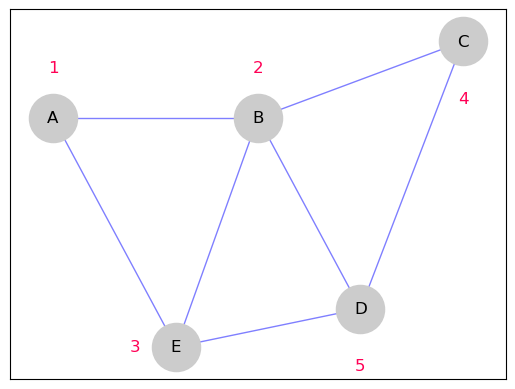

In [22]:
# NetworkX
# By definition, a Graph is a collection of nodes (vertices) along with identified pairs of nodes 
# (called edges, links, etc)
# take a look

def plot_graph(TOY_GRAPH):
    G=nx.Graph() 

    for node in TOY_GRAPH['nodes']:
        G.add_node(node)
    for edge in TOY_GRAPH['edges']:
        G.add_edge(edge[0],edge[1],weight=edge[2])

    esmall=[(u,v) for (u,v,d) in G.edges(data=True)]

    #pos=nx.spring_layout(G) # positions for all nodes
    # use the same layout for all graphs for clarity
    # positions of nodes on graph
                   # X, Y in the Cartesian coordinate system (lower left is [0, 0])
    pos = {  'A': [-1.0,  0.2],
             'B': [ 0.0,  0.2],
             'C': [ 1.0,  0.4],
             'D': [ 0.5, -0.3],
             'E': [-0.4, -0.4]}

    # positions of labels on graph
    pos2 = { 'A': [-1.0,  0.33],
             'B': [ 0.0,  0.33],
             'C': [ 1.0,  0.25],
             'D': [ 0.5, -0.45],
             'E': [-0.6, -0.4]}


    # plot nodes
    nx.draw_networkx_nodes(G,pos,node_size=1200,node_color="#cccccc")
    nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color='b')
    # Plot labels
    labels = {'A':1, 'B':2, 'E':3, 'C':4, 'D':5}
    nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
    nx.draw_networkx_labels(G,pos2,font_size=12,font_color='#ff0055',font_family='sans-serif', labels=labels)

    # Do not draw edge weigths for unweighted graph
    # edgelabels = nx.get_edge_attributes(G,'weight')
    # nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels)

    print("Graph as adjecency list")        
    print(get_adj_graph_from_edges_list(TOY_GRAPH))
    plt.axis('on')
    plt.show() # display
# a graph is a list of nodes and edges 
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1), 
         ('A', 'E', 5), 
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}
plot_graph(TOY_GRAPH)


Graph as adjecency list
{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}


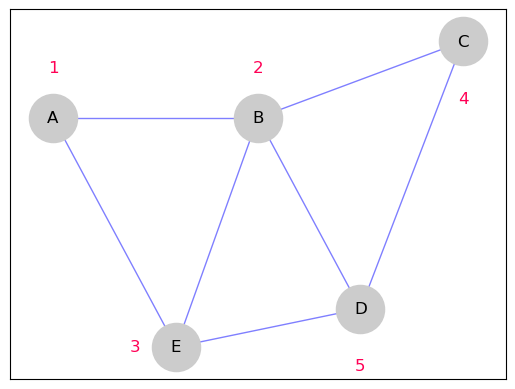

BFS Traversal:


['A', 'B', 'E', 'C', 'D']

In [23]:
# https://pythoninwonderland.wordpress.com/2017/03/18/how-to-implement-breadth-first-search-in-python/
# visits all the nodes of a graph (connected component) using BFS (FIFO)

#state of a node: visited, Queue, unvisited
# order of visiting via BFS

def bfs(graph, start):
    # keep track of all visited nodes
    explored = [] #visited
    # keep track of nodes to be checked
    queue = deque() #double ended queue
    queue.append(start)
    
    # keep looping until there are nodes still to be checked
    while queue:
        # pop shallowest node (first node) from queue
        node = queue.popleft() # FIFO queue
        if node not in explored:
            # add node to list of checked nodes
            explored.append(node)
            neighbours = graph[node]
            
            # add neighbours of node to queue
            for neighbour in neighbours:  
                queue.append(neighbour)  # refinement considerations if not already visited and not in the queue 
    return explored  #return the nodes in traversed order

# a graph is a list of nodes and edges 
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1), 
         ('A', 'E', 5), 
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}
plot_graph(TOY_GRAPH)

print("BFS Traversal:")
bfs(ADJ_GRAPH,'A') 

[1, 2, 3, 4, 5, 6, 7, 8]
[(1, 2), (1, 4), (1, 5), (2, 3), (3, 4), (3, 8), (4, 8), (5, 6), (5, 7)]
[2, 4, 5]
3
Graph as adjecency list
{1: [2, 4, 5], 2: [1, 3], 3: [2, 4, 8], 4: [3, 1, 8], 5: [1, 6, 7], 6: [5], 7: [5], 8: [4, 3]}


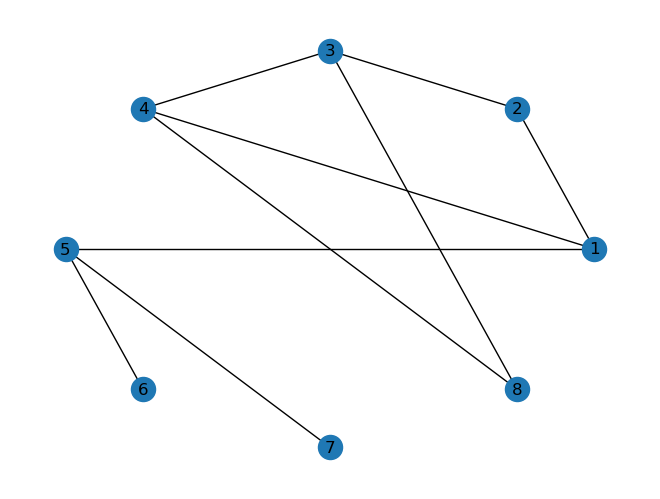

In [15]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt

g = nx.Graph()

g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 4)
g.add_edge(1, 4)
g.add_edge(1, 5)
g.add_edge(5, 6)
g.add_edge(5, 7)
g.add_edge(4, 8)
g.add_edge(3, 8)

# drawing in circular layout
nx.draw_circular(g, with_labels = True)


print(list(g.nodes))
print(list(g.edges))
#[(1, 2), (1, 3), (3, 'm')]
print(list(g.adj[1]))  # or list(G.neighbors(1))
print(g.degree[1])  # the number of edges incident to 1

# retrieving the adjacency list, 
# NOTE that we are discarding edge weights in the process of encoding
# (RUN CELL AS IS)
ADJ_GRAPH_2 = {} #unweighted
for node in g.nodes: #assume connected component with all nodes in it!
    ADJ_GRAPH_2[node] = []
        
    for neighbor in g.adj[node]:
            ADJ_GRAPH_2[node].append(neighbor)
            
print("Graph as adjecency list")        
print(ADJ_GRAPH_2)

In [16]:
print(ADJ_GRAPH_2)
print("BFS Traversal:")
bfs(ADJ_GRAPH_2,2) 

{1: [2, 4, 5], 2: [1, 3], 3: [2, 4, 8], 4: [3, 1, 8], 5: [1, 6, 7], 6: [5], 7: [5], 8: [4, 3]}
BFS Traversal:


[2, 1, 3, 4, 5, 8, 6, 7]

In [17]:
g.adj

AdjacencyView({1: {2: {}, 4: {}, 5: {}}, 2: {1: {}, 3: {}}, 3: {2: {}, 4: {}, 8: {}}, 4: {3: {}, 1: {}, 8: {}}, 5: {1: {}, 6: {}, 7: {}}, 6: {5: {}}, 7: {5: {}}, 8: {4: {}, 3: {}}})

## Example random graph

node degree clustering
0 4 0.3333333333333333
1 5 0.3
2 4 0.16666666666666666
3 4 0.5
4 4 0.16666666666666666
5 2 0
6 2 0
7 5 0.3
8 5 0.2
9 5 0.3

the adjacency list
0 8 2 9 1
1 2 4 9 3
2 7 6
3 9 8 7
4 7 6 8
5 8 9
6
7 9 8
8
9


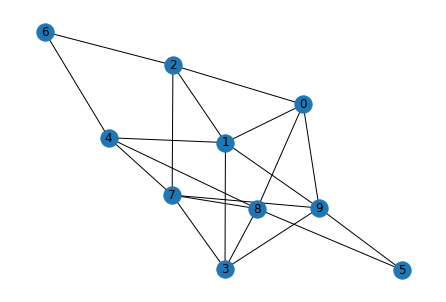

In [42]:
import matplotlib.pyplot as plt
import networkx as nx

n = 10  # 10 nodes
m = 20  # 20 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

# some properties
print("node degree clustering")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos, with_labels=True)
plt.show()

# TASK: Write BFS Search Function In Apache Spark And Pandas Dataframe: 


This Is A Pairs Notation Of The Edges, For Simplicity Of Visualization Graph = `[('A', 'B'), ('A', 'C'), ('A', 'D'), ('C', 'F'), ('F', 'A'), ('B', 'G'), ('G', 'H'), ('D', 'E')]` # Here's An Equivalent Dictionary Representation That We Can
This question hasn't been solved yet

Write BFS search function in Apache Spark and pandas dataframe:

```python
# This is a pairs notation of the edges, for simplicity of visualization
graph = [('A', 'B'),
        ('A', 'C'),
        ('A', 'D'),
        ('C', 'F'),
        ('F', 'A'),
        ('B', 'G'),
        ('G', 'H'),
        ('D', 'E')]
# Here's an equivalent dictionary representation that we can use for a
# Pandas DataFrame...
simple_dict = {'from_node': ['A', 'A', 'A', 'C', 'F', 'B', 'G', 'D'],
      'to_node': ['B', 'C', 'D', 'F', 'A', 'G', 'H', 'E']}

simple_graph_df = pd.DataFrame.from_dict(simple_dict)
simple_graph_sdf = spark.createDataFrame(simple_graph_df)
simple_graph_sdf.show()

```
As you can see, each row of this dataframe represents an edge between two nodes Although the nodes are labeled "from" and "to", the edges are actually undirected, meaning that A-->B represents the same edge as B-->A.

Let's define our starting node as follows:

smallOrig = [{'node': 'A'}]
TODO: Write spark_bfs_1_round(visted_nodes) that takes the currently dataframe of visited_nodes, performs one round of BFS, and returns an updated visited nodes dataframe. You should assume that a temporary sdf G already exists.

def spark_bfs_1_round(visited_nodes):
  """
  :param visited_nodes: dataframe with columns node and distance
  :return: dataframe of updated visuted nodes, with columns node and distance
  """
  
  #TODO
Now, run the inner function on simple_1_round_bfs_sdf result of 1 round of BFS on simple graph and store the results in simple_bfs_result. This is ultimately what the output of BFS to depth 2 should look like.

simple_graph_sdf.createOrReplaceTempView('G')
simple_bfs_result = #TODO
simple_bfs_result.show()
Convert this result to Pandas, sorted by the node.

simple_bfs_test = #TODO
Now, we will fully implement spark_bfs. This function should iteratively call your implemented version of spark_bfs_1_round and ultimately return the output of this function at max_depth.

You are also responsible for initializing the starting dataframe, that is converting the list of origin nodes into a spark dataframe with the nodes logged at distance 0.

Consider the following:

schema = StructType([
            StructField("node", StringType(), True)
        ])

    my_sdf = spark.read.format("csv").schema(schema).load("my.csv")
The schema ultimately specifies the structure of the Spark DataFrame with a string node column. It then calls spark.load to read the CSV with this schema. Also, you are responsible for ensuring that a view of your graph is available within this function. (Note: you will also need to add in a distance column)

TODO: implement spark_bfs(G,origins,max_depth) and run on review_graph_sdf initalized in 4.3. Note: you may want to run tests on the simple_graphexample as the review_graph_sdf will take quite some time to run.

## TODO: iterative search over undirected graph


In [18]:
# start Spark Session (RUN THIS CELL AS IS)
#Step A: Start Spark by running the following cell

from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'lab09_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

# Don't worry about messages shown below

Spark is already running
yarn appName: PySparkShell


In [19]:
import pandas as pd
graph = [('A', 'B'),
        ('A', 'C'),
        ('A', 'D'),
        ('C', 'F'),
        ('F', 'A'),
        ('B', 'G'),
        ('G', 'H'),
        ('D', 'E')]
# Here's an equivalent dictionary representation that we can use for a
# Pandas DataFrame...
simple_dict = {'from_node': ['A', 'A', 'A', 'C', 'F', 'B', 'G', 'D'],
      'to_node': ['B', 'C', 'D', 'F', 'A', 'G', 'H', 'E']}

simple_graph_df = pd.DataFrame.from_dict(simple_dict)
simple_graph_sdf = spark.createDataFrame(simple_graph_df)
simple_graph_sdf.show()

def spark_bfs(G, origins, max_depth):
  """ runs distributed BFS to a specified max depth

  :param G: graph dataframe from 4.3
  :param origins: list of origin nodes stored as {"node": nodeValue}
  :param max_depth: integer value of max depth to run BFS to
  :return: dataframe with columns node, distance of all visited nodes
  """

  #TODO 
  # Remember that if you want to go from Pandas dataframes to Spark dataframes,
  # you may need to write to a CSV and read it back.

+---------+-------+
|from_node|to_node|
+---------+-------+
|        A|      B|
|        A|      C|
|        A|      D|
|        C|      F|
|        F|      A|
|        B|      G|
|        G|      H|
|        D|      E|
+---------+-------+



### Starter for BFS implementation in PySpark

* Please adapt the following code to complete an implementation in PySpark of the BFS traversal of a graph.
* Please adapt the following code to complete an implementation in PySpark of the SSSP for an unweighted graph.

In [ ]:
#Assume the input file contains in each line a vertex ID and its adjacency list.
#Function
def getAdjListPairData returns a pair of vertex ID and its adjacency list, creating a pair RDD.
graph = sc.textFile (…).map( line => getAdjListPairData (line)

#Add some code here to make sure that graph has a Partitioner . This is needed for avoiding shuffling
# in the join below.
## ......
## Ask Spark to try and keep this pair RDD around in memory for efficient re

graph.persist

# The active vertex set initially only contains source vertex s, which needs to be passed through the
# context. Create a pair RDD for s. Value 1 is a dummy value.
activeVertices = sc.parallelize ( (“s”, 1)

# Function
def extractVerticesAsPair returns each vertex id m in the adjacency list as (m, 1),// where 1 is a dummy value.

for (iterationCount 1 to k) {
   activeVertices = graph.join ( activeVertices)\
                         .flatMap ( (id, adjList , dummy) => extractVerticesAsPair adjList )\
                         .reduceByKey ( (x, y) => x )// Remove duplicate vertex occurrences
}

# Exercise 4. SSSP for unweighted graphs.

The "Single Source Shortest Path" (SSSP) problem is a particular kind of analysis for which we will need to traverse a graph. As implied by the name, when performing SSSP we assume that you have a particular 'starting node' in mind, and want to end up with a number that represents the 'length' of the most efficient route you could take to arrive at a destination (possibly also the path itself which would be a list of connected nodes). Note that in some cases we'll want to calculate this distance ___for all other nodes in the graph___, in others we'll have a ___particular destination node in mind___. Depending on which outcome we're seeking we'd make different design choices.

For an unweighted undirected graph, the 'length' of a path is just the number of edges that are part of that path. We can measure these distances easily by traversing the graph and incrementing counters each time we 'travel' an edge. While doing this traversal, we'll also keep track of which nodes have already been visited so that we can store their shortest distances and so that we know when we've fully traversed the graph. Note that in many graphs there will be more than one path from the source to a given node, in such cases we'll want a way to ensure that we're keeping track of the _shortest_ path not just the path that we happened to find first. BFS guarantees that the first path we find _will_ be the shortest (_can you explain why?_). Here's what it would look like:

Graph as adjecency list
{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}


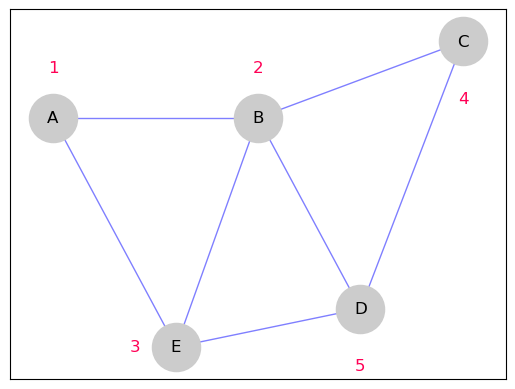

In [24]:
# a graph is a list of nodes and edges 
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1), 
         ('A', 'E', 5), 
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}
plot_graph(TOY_GRAPH)


In [20]:
ADJ_GRAPH
#Graph as adjecency list 
#{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}
ADJ_GRAPH = {'A': ['B', 'E'],
 'B': ['A', 'C', 'D', 'E'],
 'C': ['B', 'D'],
 'D': ['B', 'C', 'E'],
 'E': ['A', 'B', 'D']}
ADJ_GRAPH
# node 0 (node 1),   1(2)        2(3)         3(4)      4(5)
#[[1, 2],           [2,3,4], [0, 1, 4], [1, 4], [1,2,3]]

{'A': ['B', 'E'],
 'B': ['A', 'C', 'D', 'E'],
 'C': ['B', 'D'],
 'D': ['B', 'C', 'E'],
 'E': ['A', 'B', 'D']}

### implement SSSP by modifying the following BFS code

In [ ]:
# https://pythoninwonderland.wordpress.com/2017/03/18/how-to-implement-breadth-first-search-in-python/
# visits all the nodes of a graph (connected component) using BFS (FIFO)

#state of a node: visited, Queue, unvisited
# order of visiting via BFS

def bfs(graph, start):
    # keep track of all visited nodes
    explored = [] #visited
    # keep track of nodes to be checked
    queue = deque() #double ended queue
    queue.append(start)
    
    # keep looping until there are nodes still to be checked
    while queue:
        # pop shallowest node (first node) from queue
        node = queue.popleft() # FIFO queue
        if node not in explored:
            # add node to list of checked nodes
            explored.append(node)
            neighbours = graph[node]
            
            # add neighbours of node to queue
            for neighbour in neighbours:  
                queue.append(neighbour)  # refinement considerations if not already visited and not in the queue 
    return explored  #return the nodes in traversed order

# a graph is a list of nodes and edges 
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1), 
         ('A', 'E', 5), 
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}
plot_graph(TOY_GRAPH)

print("BFS Traversal:")
bfs(ADJ_GRAPH,'A') 

### Solution

Adapted from: [here](https://www.geeksforgeeks.org/shortest-path-unweighted-graph/)

In [8]:
from collections import deque
# Adapted from: [here](https://www.geeksforgeeks.org/shortest-path-unweighted-graph/)
def bfs_shortest_path(graph, start):
    # Create a queue and add the starting vertex to it
    queue = deque([start])
    
    # Create an array to keep track of the distances from the starting vertex to all other vertices
    distances = [float('inf')] * len(graph)
    distances[start] = 0
    
    # Create a set to keep track of visited vertices
    visited = set()
    
    # Perform BFS
    while queue:
        # Dequeue the next vertex
        vertex = queue.popleft()
        visited.add(vertex)

        # Update the distances of neighbors
        for neighbor in graph[vertex]:
            if neighbor not in visited:
                distances[neighbor] = distances[vertex] + 1
                queue.append(neighbor)

    return distances


# Example graph: unweighted, directed graph with 5 vertices
# Vertices are represented by integers 0 through 4
# Edges: (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4)
graph = [[1, 2], [2, 3], [3], [4], []]

start_vertex = 0
distances = bfs_shortest_path(graph, start_vertex)
print(distances) # Output: [0, 1, 1, 2, 3]

# Graph taken from above
#Graph as adjecency list
#{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}
# Graph nodes remapped to integers
# A  0
# B  1
# C  2
# D  3
# E  4

graph = [[1, 4],  [0, 2,3,4], [2, 3], [1, 2, 4], [0, 1, 3]]

start_vertex = 0
distances = bfs_shortest_path(graph, start_vertex)
print(distances) # 
print(f"Distance from node (0) to node (4) is {distances[4]}")

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 2]
Distance from node (0) to node (4) is 2


### Alternative implementation: instead of storing distance, store the actual path from the source node

Graph as adjecency list
{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}


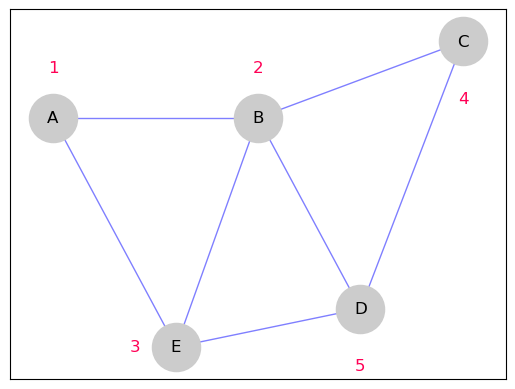

BFS Shortest paths
visited: [];  queue: deque([['A']])
visited: ['A'];  queue: deque([['A', 'B'], ['A', 'E']])
(['A', 'B', 'D'], 2)


In [27]:
# finds shortest path between 2 nodes of a graph using BFS
# Does not consider edge weights

def bfs_shortest_path(graph, start, goal):
    """ SSSP for unweighted graphs  
        from start to an goal node
        Each record is the queue is a path from the source node to that node"""
    
    # keep tracvisit of explored nodes
    explored = []
    # keep track of all the paths to be checked
    queue = deque()
    # deque([['A', 'B'], ['A', 'E']]) for this graph
    # queue: deque([[2, 1, 2], [2, 1, 4], [2, 1, 5], [2, 3, 2], [2, 3, 4], [2, 3, 8]])
    queue.append([start])

    distance = 0
    # return path if start is goal
    if start == goal:
        return "That was easy! Start = goal"
    level = 0
    # keeps looping until all possible paths have been checked
    while queue: #  que is a list of paths where the last element is the node of interest
        # import pdb; pdb.set_trace() #breakpoint; dont forget q to quit of h for help
        print(f"visited: {explored};  queue: {queue}")
        # pop the first path from the queue
        path = queue.popleft() #fifo
        # get the last node from the path
        node = path[-1]  # store "the path to the node from src_node" in the queue. so just extract the node only
                         # [2, 1, 5]  get node 5
        if node not in explored:  #process the neigbors
            neighbours = graph[node] #neighbors (adjacency graph)
            # go through all neighbour nodes, construct a new path and
            # push it into the queue
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                # que is a list of paths where the last element is the node of interest
                # queue consists of [A B]; the node in the queue is B  
                queue.append(new_path)  # add all neighbors to que
                # return path if neighbour is goal
                if neighbour == goal:
                    distance = len(new_path)-1 # for an unweighted graph, distance is just the number of hops
                    return new_path, distance

            # mark node as explored/visited
            explored.append(node)

    # in case there's no path between the 2 nodes
    return "So sorry, but a connecting path doesn't exist :("

plot_graph(TOY_GRAPH)
print("BFS Shortest paths")
print(bfs_shortest_path(ADJ_GRAPH, 'A', 'D') )

__DISCUSSION QUESTIONS:__ What would go wrong with this approach if the graph were weighted?

> Depending on the weight, the path that you need to take changes. Breadth first search cannot be used for a weighted graph. With weighted graphs, we cannot do FIFO but rather a priority queue.

## SSSP with a more illustrative example



[1, 2, 3, 4, 5, 6, 7, 8]
[(1, 2), (1, 4), (1, 5), (2, 3), (3, 4), (3, 8), (4, 8), (5, 6), (5, 7)]
[2, 4, 5]
3
{1: [2, 4, 5], 2: [1, 3], 3: [2, 4, 8], 4: [3, 1, 8], 5: [1, 6, 7], 6: [5], 7: [5], 8: [4, 3]}
BFS Shortest paths
__________________________________________________
visited: [];  queue: deque([[2]])
visited: [2];  queue: deque([[2, 1], [2, 3]])
visited: [2, 1];  queue: deque([[2, 3], [2, 1, 2], [2, 1, 4], [2, 1, 5]])
visited: [2, 1, 3];  queue: deque([[2, 1, 2], [2, 1, 4], [2, 1, 5], [2, 3, 2], [2, 3, 4], [2, 3, 8]])
visited: [2, 1, 3];  queue: deque([[2, 1, 4], [2, 1, 5], [2, 3, 2], [2, 3, 4], [2, 3, 8]])
visited: [2, 1, 3, 4];  queue: deque([[2, 1, 5], [2, 3, 2], [2, 3, 4], [2, 3, 8], [2, 1, 4, 3], [2, 1, 4, 1], [2, 1, 4, 8]])
bfs_shortest_path(ADJ_GRAPH, 2, 7) is ([2, 1, 5, 7], 3)


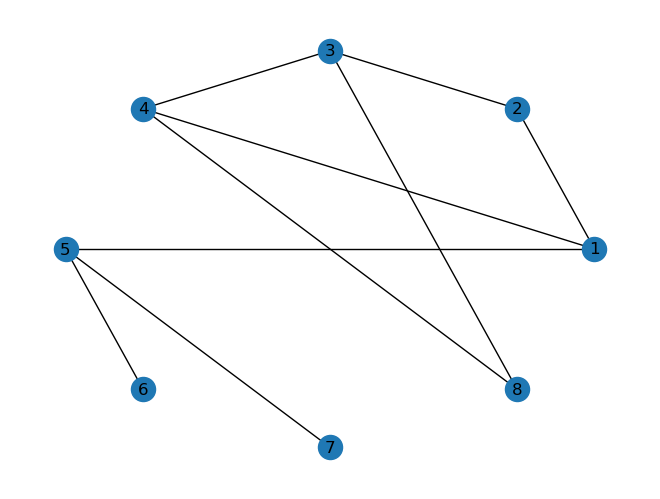

In [28]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt

g = nx.Graph()

g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 4)
g.add_edge(1, 4)
g.add_edge(1, 5)
g.add_edge(5, 6)
g.add_edge(5, 7)
g.add_edge(4, 8)
g.add_edge(3, 8)

# drawing in circular layout
nx.draw_circular(g, with_labels = True)


print(list(g.nodes))
print(list(g.edges))
#[(1, 2), (1, 3), (3, 'm')]
print(list(g.adj[1]))  # or list(G.neighbors(1))
print(g.degree[1])  # the number of edges incident to 1

# retrieving the adjacency list, 
# NOTE that we are discarding edge weights in the process of encoding
# (RUN CELL AS IS)
ADJ_GRAPH_2 = {} #unweighted
for node in g.nodes: #assume connected component with all nodes in it!
    ADJ_GRAPH_2[node] = []
        
    for neighbor in g.adj[node]:
            ADJ_GRAPH_2[node].append(neighbor)
            
print(ADJ_GRAPH_2)
print("BFS Shortest paths")
print("_"*50)
print(f"bfs_shortest_path(ADJ_GRAPH, 2, 7) is {bfs_shortest_path(ADJ_GRAPH_2, 2, 7)}" )

## SSSP for a random graph

node degree clustering
0 4 0.3333333333333333
1 5 0.3
2 4 0.16666666666666666
3 4 0.5
4 4 0.16666666666666666
5 2 0
6 2 0
7 5 0.3
8 5 0.2
9 5 0.3

the adjacency list
0 8 2 9 1
1 2 4 9 3
2 7 6
3 9 8 7
4 7 6 8
5 8 9
6
7 9 8
8
9


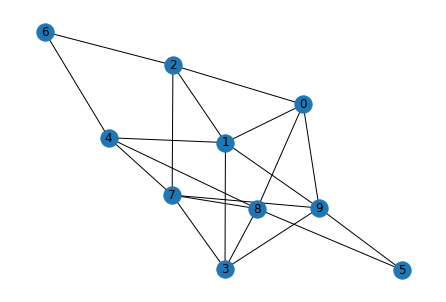

{0: [8, 2, 9, 1], 1: [2, 4, 9, 3, 0], 2: [1, 7, 6, 0], 3: [9, 8, 1, 7], 4: [7, 1, 6, 8], 5: [8, 9], 6: [4, 2], 7: [4, 2, 9, 3, 8], 8: [0, 5, 3, 4, 7], 9: [1, 3, 5, 7, 0]}
BFS Shortest paths
__________________________________________________
queue: deque([[5]])
queue: deque([[5, 8], [5, 9]])
queue: deque([[5, 9], [5, 8, 0], [5, 8, 5], [5, 8, 3], [5, 8, 4], [5, 8, 7]])
queue: deque([[5, 8, 0], [5, 8, 5], [5, 8, 3], [5, 8, 4], [5, 8, 7], [5, 9, 1], [5, 9, 3], [5, 9, 5], [5, 9, 7], [5, 9, 0]])
queue: deque([[5, 8, 5], [5, 8, 3], [5, 8, 4], [5, 8, 7], [5, 9, 1], [5, 9, 3], [5, 9, 5], [5, 9, 7], [5, 9, 0], [5, 8, 0, 8], [5, 8, 0, 2], [5, 8, 0, 9], [5, 8, 0, 1]])
queue: deque([[5, 8, 3], [5, 8, 4], [5, 8, 7], [5, 9, 1], [5, 9, 3], [5, 9, 5], [5, 9, 7], [5, 9, 0], [5, 8, 0, 8], [5, 8, 0, 2], [5, 8, 0, 9], [5, 8, 0, 1]])
queue: deque([[5, 8, 4], [5, 8, 7], [5, 9, 1], [5, 9, 3], [5, 9, 5], [5, 9, 7], [5, 9, 0], [5, 8, 0, 8], [5, 8, 0, 2], [5, 8, 0, 9], [5, 8, 0, 1], [5, 8, 3, 9], [5, 8, 3, 8], [

In [52]:
import matplotlib.pyplot as plt
import networkx as nx

n = 10  # 10 nodes
m = 20  # 20 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
g_random = nx.gnm_random_graph(n, m, seed=seed)

# some properties
print("node degree clustering")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)

pos = nx.spring_layout(g_random, seed=seed)  # Seed for reproducible layout
nx.draw(g_random, pos=pos, with_labels=True)
plt.show()

ADJ_GRAPH_2 = {} #unweighted
for node in g_random.nodes: #assume connected component with all nodes in it!
    ADJ_GRAPH_2[node] = []
        
    for neighbor in g_random.adj[node]:
            ADJ_GRAPH_2[node].append(neighbor)
            
print(ADJ_GRAPH_2)
print("BFS Shortest paths")
print("_"*50)
print(f"\n\nbfs_shortest_path(ADJ_GRAPH, 5, 6) is {bfs_shortest_path(ADJ_GRAPH_2, 5, 6)}" )

# Exercise 5: Dijkstra's algorithm (SSSP for weighted graphs)

Dijkstra's algorithm uses a modified BFS with weights and a priority queue to solve this problem.

1. new path an improvement over a possible previous one.   
Check whether the path just discovered to the vertex v' is an improvement on the previously discovered path (which had length d)

2. The queue q should not be a FIFO queue.    
Instead, it should be a priority queue where the priorities of the vertices in the queue are their distances recorded in visited. 

pop(q) should be a priority queue extract_min operation that removes the vertex with the smallest distance.

The priority queue must also increase_priority(q,v)    
Increases the priority of an element v already in the queue q. 

A nice intuitive explanation can be found in this 10 minute video: https://www.youtube.com/watch?v=pVfj6mxhdMw

See also __A*__ algorithm: https://youtu.be/eSOJ3ARN5FM

__Assumptions:__
- Dijkstra is a __greedy algorithm__: We assume that we have made the best choice possible in every step of the algorithm. 
- The Graph has __no negative edges__: If edges are negative a greedy algorithm will not suffice.

The __Bellman–Ford__ algorithm can be used on graphs with negative edge weights, as long as the graph contains no negative cycle reachable from the source vertexs. 

With negative cycles the total weight becomes lower each time the cycle is traversed. 
__Johnson's algorithm__ combines Dijkstra's algorithm with Bellman-Ford to handle negative weight edges by removing negative edges and detecting negative cycles.

#### What about longest pahs?
Finding the longest simple path between two vertices is NP-Complete, In fact, it is NP-Complete even if all edge weights are 1   
https://sarielhp.org/misc/funny/longestpath.mp3

## 
The heapq implements a min-heap sort algorithm suitable for use with Python's lists.

This module provides an implementation of the heap queue algorithm, also known as the priority queue algorithm.

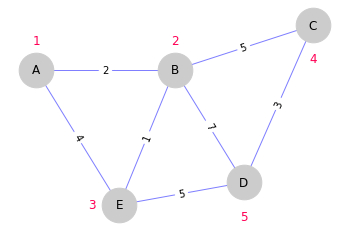

In [7]:
# take a look
G=nx.Graph()

for node in TOY_GRAPH['nodes']:
    G.add_node(node)
for edge in TOY_GRAPH['edges']:
    G.add_edge(edge[0],edge[1],weight=edge[2])

esmall=[(u,v) for (u,v,d) in G.edges(data=True)]

#pos=nx.spring_layout(G) # positions for all nodes
# use the same layout for all graphs for clarity
pos = {  'A': [-1.0,  0.2],
         'B': [ 0.0,  0.2],
         'C': [ 1.0,  0.4],
         'D': [ 0.5, -0.3],
         'E': [-0.4, -0.4]}

pos2 = { 'A': [-1.0,  0.33],
         'B': [ 0.0,  0.33],
         'C': [ 1.0,  0.25],
         'D': [ 0.5, -0.45],
         'E': [-0.6, -0.4]}


# nodes
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color="#cccccc")
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color='b')

# labels
labels = {'A':1, 'B':2, 'E':3, 'C':4, 'D':5}
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
nx.draw_networkx_labels(G,pos2,font_size=12,font_color='#ff0055',font_family='sans-serif', labels=labels)

# Do not draw edge weigths for unweighted graph
edgelabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels)

plt.axis('off')
plt.show() # display

In [8]:
# helper class for representing graphs
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}
 
    def add_node(self, value):
        self.nodes.add(value)
 
    def add_edge(self, node1, node2, distance = 1,direct = False):
        self.edges[node1].append(node2)
        self.distances[(node1, node2)] = distance
        if not direct:
            self.edges[node2].append(node1)
            self.distances[(node2, node1)] = distance

In [9]:
import re
import heapq
import itertools
import numpy as np
import networkx as nx
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

# Single thread Dijskra's implementation
def dijkstra(graph, initial):
    """ 
    GOAL: Shortest distances from node A to all other nodes
    A node can be one of three states
           Visited
           Queue
           Unvisited
    """
    visited = {initial: 0} 
    heap = [(0, initial)] # our priority queue
    path = {}

    nodes = set(graph.nodes) # unvisited state

    while nodes and heap: #priority queue
        
        current_weight, min_node = heapq.heappop(heap)
        try:
            while min_node not in nodes: # get next unvisited node with highest priority 
                current_weight, min_node = heapq.heappop(heap)
        except IndexError:
            break

        nodes.remove(min_node) # highest priority
        
        for v in graph.edges[min_node]:
            weight = current_weight + graph.distances[min_node, v]
            if v not in visited or weight < visited[v]:
                visited[v] = weight
                heapq.heappush(heap, (weight, v))
                path[v] = min_node
    return visited



In [10]:
# take a look
g = Graph()

for node in nodes:
    g.add_node(node)
for edge in edges:
    g.add_edge(*edge)
    
print("Shortest distances from node A to all other nodes" )   
print("lengths", dijkstra(g, 'A'))
print("="*50)

Shortest distances from node A to all other nodes
lengths {'A': 0, 'B': 2, 'E': 3, 'C': 7, 'D': 8}


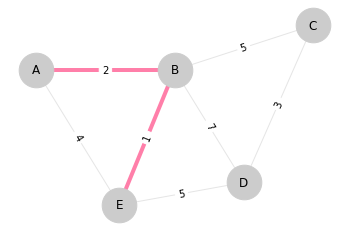

sanity check using networkx
lenghts {'A': 0, 'B': 2, 'E': 3, 'C': 7, 'D': 8}
paths {'A': ['A'], 'B': ['A', 'B'], 'E': ['A', 'B', 'E'], 'C': ['A', 'B', 'C'], 'D': ['A', 'B', 'E', 'D']}


In [11]:
####### networkx ########

G=nx.Graph()

for node in nodes:
  G.add_node(node)
for edge in edges:
  G.add_edge(edge[0],edge[1],weight=edge[2])

esmall=[(u,v) for (u,v,d) in G.edges(data=True)]

# nodes
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color="#cccccc")
# edges
edgeWidths = []
edgeColors = []
for edge in G.edges:
    if edge in [('A', 'B'),('B', 'E'),('E', 'D')]:
        edgeWidths.append(4)
        edgeColors.append("#ff0055")
    else:
        edgeWidths.append(1)
        edgeColors.append("#cccccc")

nx.draw_networkx_edges(G,pos,edgelist=esmall,width=edgeWidths,alpha=0.5,edge_color=edgeColors)

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.axis('off')
plt.show() 

print("="*50)
print("sanity check using networkx")
print("lenghts",nx.single_source_dijkstra_path_length(G,"A") )
print("paths",nx.single_source_dijkstra_path(G,"A") )

* __DISCUSSION QUESTION:__ Why won't this approach scale?

> There's no way to know the priority. The priorities are kind of like a global variable so it is kinda of complicated to balance this because the priority is looking at everything at the same thing. There could be race condition issues involved.


# Exercise 6. Distributed SSSP

#### Graph algorithms typically involve:
- Performing computation at each node
- Processing node-specific data, edge-specific data, and  link structure
- Traversing the graph in some manner

#### Key questions:
- How do you represent graph data in MapReduce?
- How do you process a graph in stateless MapReduce?

*For maximum parallelism, you need the Maps and Reduces to be stateless, i.e. to not depend on any data generated in the same MapReduce job. You cannot control the order in which the maps run, or the reductions.*


### Distributed SSSP Algorithm

#### Node STATES
- Visited
- Queue
- Unvisited

#### Phase 1 - Initialize graph
- Start with Source node (node 1)
- Mark node 1 with distance=0 and tag Q “frontier queue.”
- Mark all other nodes in the unvisited state U, and distance inf


|Key|Value|.|.|
|----|---------|--------|-----|
|Node|Out_nodes|distance|state|
|A|B,E|0|Q|
|B|A,C,D,E|inf|U|
|C|B,D|inf|U|  
|D|B,C,E|inf|U|
|E|A,B,D|inf|U|

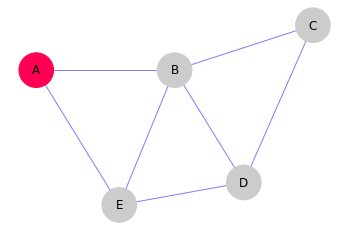

In [12]:
# nodes
color_map = []
for node in G:
    if node == "A":
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,edge_color='b')

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show() # display

### Mappers: Expand the “frontier”

#### For each frontier node, expand(): 

- Emit list of new frontier nodes tagged with `Q`, and `distance = distance + 1`. 
- Mappers dont know down stream edges from new frontier nodes: tag them as `Null`
- Old frontier updated to visited `V` (once a node has been expanded, we're done with it). 
- Emit all “unvisited nodes” `U`, with no change. 

#### Mapper output:


|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|*Null*|1|Q|
|E|:|*Null*|1|Q|
|B|:|A,C,D,E|inf|U|
|C|:|B,D|inf|U|  
|D|:|B,C,E|inf|U|
|E|:|A,B,D|inf|U|


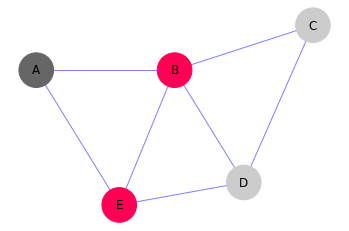

In [13]:
# nodes
color_map = []
for node in G:
    if node == "A":
        color_map.append("#666666")
    elif node == "B" or node == "E":
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,edge_color='b')

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show() # display

### Reducers: Merge candidate paths

- The SSSP reducers receive all data for a given key 
- They receive the Null "copies" from newly expanded frontier nodes
- They also recieve info on down stream nodes for that key
- The reducers combine as new key-value pair for next cycle
    - Out_nodes: Union all values
    - Distance: Take the min
    - State: 
        - UNweighted Graph: 
            - `if Q,V:    new_state = V`  
            - `if Q,U:    new_state = Q` 

#### Reducer input:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|B|:|Null|1|Q|
|B|:|A,C,D,E|inf|U|

#### Reducer output:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|B|:|A,C,D,E|1|Q|


### When Does The Algorithm Terminate?
Eventually, all nodes will pass through Q and then V states
(in a connected graph)

#### Stopping conditions:
When there are no output nodes that are frontier (i.e., in Q state). 


### Distributed SSSP from node '1' to each other node:

#### After Initilization phase:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|Q|
|B|:|A,C,D,E|inf|U|
|C|:|B,D|inf|U|  
|D|:|B,C,E|inf|U|
|E|:|A,B,D|inf|U|

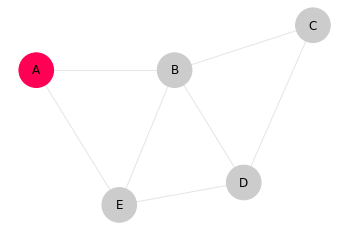

In [14]:
color_map = []
for node in G:
    if node == "A": color_map.append("#ff0055")
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

#### After First Iteration:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|A,C,D,E|1|Q|
|C|:|B,D|inf|U|  
|D|:|B,C,E|inf|U|
|E|:|A,B,D|1|Q|

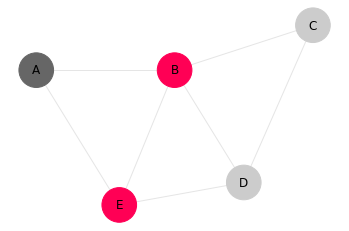

In [15]:
color_map = []
for node in G:
    if node == "A":
        color_map.append("#666666")
    elif node in ["B","E"]:
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

#### After Second Iteration:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|A,C,D,E|1|V|
|C|:|B,D|2|Q|  
|D|:|B,C,E|2|Q|
|E|:|A,B,D|1|V|

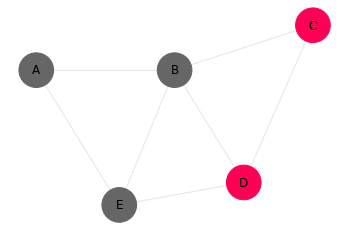

In [16]:
color_map = []
for node in G:
    if node in ["A","B","E"]:
        color_map.append("#666666")
    elif node in ["D","C"]:
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

#### After Third Iteration:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|A,C,D,E|1|V|
|C|:|B,D|2|V|  
|D|:|B,C,E|2|V|
|E|:|A,B,D|1|V|

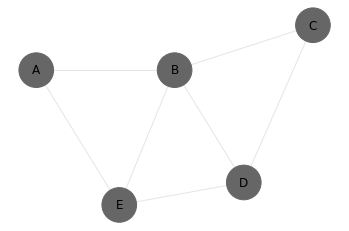

In [17]:
color_map = []
for node in G:
    if node in ["A","B","E","D","C"]:
        color_map.append("#666666")
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

### Will this code work for weighted graphs?


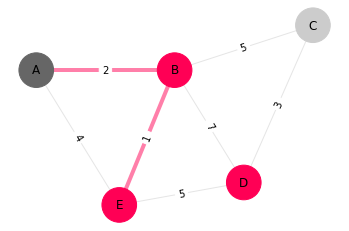

In [18]:
color_map = []
for node in G:
    if node == "A":
        color_map.append("#666666")
    elif node in ["B","E","D"]:
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)

# edges
edgeWidths = []
edgeColors = []
for edge in G.edges:
    if edge in [('A', 'B'),('B', 'E'),('E', 'D')]:
        edgeWidths.append(4)
        edgeColors.append("#ff0055")
    else:
        edgeWidths.append(1)
        edgeColors.append("#cccccc")

nx.draw_networkx_edges(G,pos,edgelist=esmall,width=edgeWidths,alpha=0.5,edge_color=edgeColors)

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

Modify MapReduce Iteration Job for unweighted graphs as follows to get the weighted version:
- If distance to a visited node is shorter then reset status to frontier Q


__The mapper__ 
- same as above.

__The reducer__
- The SSSP reducers receive all data for a given key 
- They receive the Null "copies" from newly expanded frontier nodes
- They also recieve info on down stream nodes for that key
- The reducers combine as new key-value pair for next cycle
    - Out_nodes: Union all values
    - Distance: Take the min
    - State: 
        - UNweighted Graph: 
            - `if Q,V:    new_state = V`  
            - `if Q,U:    new_state = Q` 
        - Weighted Graph: 
            - `if Q,V and distance(Q) < distance(V):    new_state = Q`
                - `else:    new_state = V` 
            - `if Q,U:    new_state = Q` 

## Optional Quiz: weighted SSSP via Map-Reduce 
<img src="https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week09/sssp_quiz.png">

__INSTRUCTOR TALKING POINTS__
> 8!

## Optional: Implement Dijkstra Shortest Path

* Implement Dijkstra's Shortest Path in Apache Spark (for weighted SSSP).

Please use the following code bases as starting points:
* https://github.com/bilal-elchami/dijkstra-hadoop-spark
* https://raw.githubusercontent.com/Abhishek-Arora/Dijkstra-Shortest-Path/master/shortest_path.py

Use the above graph as a unit test for your code 

## Dijkstra's SSSP for unweighted 

* Things get simpler in Map-Reduce land:
  * no need for a priority queue
  * visit each level by level (like BFS). E.g., [here](https://www.prodevelopertutorial.com/wp-content/uploads/2019/08/28-1.png)
  
  
  
  
  <img src="https://www.prodevelopertutorial.com/wp-content/uploads/2019/08/28-1.png">

# GraphFrames Library

## GraphFrames Overview
GraphFrames is a package for Apache Spark which provides DataFrame-based Graphs. It provides high-level APIs in Scala, Java, and Python. It aims to provide both the functionality of GraphX and extended functionality taking advantage of Spark DataFrames. This extended functionality includes motif finding, DataFrame-based serialization, and highly expressive graph queries.

## What are GraphFrames?
GraphFrames are to DataFrames as GraphX is to RDDs.

* GraphFrames represent graphs: vertices (e.g., users) and edges (e.g., relationships between users). If you are familiar with GraphX, then GraphFrames will be easy to learn. The key difference is that GraphFrames are based upon Spark DataFrames, rather than RDDs.

* GraphFrames also provide powerful tools for running queries and standard graph algorithms. With GraphFrames, you can easily search for patterns within graphs, find important vertices, and more. Refer to the User Guide for a full list of queries and algorithms.

## Will GraphFrames be part of Apache Spark?

The GraphX component of Apache Spark has no DataFrames- or Dataset-based equivalent, so it is natural to ask this question. The current plan is to keep GraphFrames separate from core Apache Spark for the time being:

## ACTION ITEM:  GraphFrames in action
The following is a link to a notebook that demonstrates examples of using various graph based algorihtms available in the  GraphFrames package. Please REVIEW it carefully:

* https://docs.databricks.com/integrations/graphframes/user-guide-python.html

# GraphX (Java and Scala APIs only)

GraphX unifies ETL, exploratory analysis, and iterative graph computation within a single system. You can view the same data as both graphs and collections, transform and join graphs with RDDs efficiently, and write custom iterative graph algorithms using the *Pregel* Message Passing API.

In addition to a highly flexible API, GraphX comes with a variety of graph algorithms, many of which were contributed by our users.

* PageRank
* Connected components
* Label propagation
* SVD++
* Strongly connected components
* Triangle count

# Full Pagerank via RDDs



In [3]:
### PageRank
import re
import sys
from operator import add
from typing import Mapping,Tuple
from pyspark.resultiterable import ResultIterable
from pyspark.sql import SparkSession


def parse_directed_edge_node(edge: str) -> Tuple[str, str]:
    """Parses a urls pair string into urls pair.
    node[0] --> node[1]"""
    nodes = re.split(r'\s+', edge)
    return nodes[0], nodes[1]

def extract_nodes(urls: str):
    """output nodes in an edge"""
    parts = re.split(r'\s+', urls)
    yield parts[0]
    yield parts[1]
    
def assign_PR_mass_to_nbors_or_to_dangling_mass(node, page_rank_mass, outlinks, dangling_node_mass): # -> Iterable[Tuple[str, float]]:
    """ distribute the pagerank mass for a node to the neighbors it points to (its outlinks). 
        Or if there is no outgoing link add the pagerank mass to the dangling mass"""
    if outlinks: # Redistribute  mass of node amongst neigbbors (outgoing links)
        num_of_outlinks = len(outlinks)
        for outlink in outlinks:
            yield (outlink, page_rank_mass / num_of_outlinks)
    else: # accumulate dangling mass as there are no outgoing links for this node
        dangling_node_mass += page_rank_mass
    yield node, 0.0
            
edges_str = """1 2
1 3
1 4
2 1
3 1
4 3
4 1"""

edges_str = """D A
D B
X B
X E
Y B
Y E
Z B
Z E
M E
N E
F E
E F
F B
B C
C B
E B
E D"""
iterations = 100
alpha = 0.15
edges_rdd = sc.parallelize(list(edges_str.split("\n")))
print(f"edges_rdd: {edges_rdd.collect()}")
# Loads all URLs from input file and initialize their neighbors.
graph_adjacency_list = edges_rdd.map(lambda edge: parse_directed_edge_node(edge)).distinct().groupByKey().cache()
print(f"graph_adjacency_list---------")
for node_and_neighbors in graph_adjacency_list.collect(): 
  print(f"Node {node_and_neighbors[0]}: {','.join(node_and_neighbors[1])} ")

# graph_adjacency_list.collect()[0][0]
# Loads all URLs from input file and initialize their neighbors.
unique_nodes = edges_rdd.flatMap(lambda edge: extract_nodes(edge)).distinct()
unique_nodes_count = unique_nodes.count()
print(f"unique_nodes_count: {unique_nodes_count}.  unique_nodes: {unique_nodes.collect()};  ")
#.map(lambda url: (url, 1.0))
page_rank = unique_nodes.map(lambda url: (url, 1.0/unique_nodes_count))
print(f"Initialized page_rank: ")
page_rank_sorted = sorted(page_rank.collect(), key=lambda x:-x[1])
print("\n".join([f"{node},{round(page_rank, 3)}" for node,page_rank in page_rank_sorted]))

teleportation_factor = alpha/unique_nodes_count

# Iteratively, update the pagerank of each URL using PageRank algorithm.
from tqdm import tqdm # progress bar

for iteration in tqdm(range(iterations)): # progress bar
    # Accumulate page rank mass from all incoming links
    # Accumulate mass from deadend nodes
    dangling_node_mass = sc.accumulator(float(0.0))
    pr_mass_from_nbors = page_rank.leftOuterJoin(graph_adjacency_list)\
         .flatMap(lambda url_urls_rank: assign_PR_mass_to_nbors_or_to_dangling_mass(url_urls_rank[0], url_urls_rank[1][0], url_urls_rank[1][1], dangling_node_mass) )
    dangling_node_mass_per_node = dangling_node_mass.value/unique_nodes_count
    dangling_node_mass_per_node = 0.0
    # Accumulate page rank mass from all incoming links, dangling node mass, and from the teleportation graph
    page_rank = pr_mass_from_nbors.reduceByKey(add).mapValues(lambda rank: (dangling_node_mass_per_node + rank) * (1.0 - alpha) + teleportation_factor)

# Print each node/URL and corresponding page rank
page_rank = sorted(page_rank.collect(), key=lambda x:-x[1])
print("\n".join([f"{node},{round(page_rank, 3)}" for node,page_rank in page_rank]))

edges_rdd: ['D A', 'D B', 'X B', 'X E', 'Y B', 'Y E', 'Z B', 'Z E', 'M E', 'N E', 'F E', 'E F', 'F B', 'B C', 'C B', 'E B', 'E D']
graph_adjacency_list---------
Node N: E 
Node C: B 
Node D: A,B 
Node X: B,E 
Node Y: B,E 
Node Z: B,E 
Node M: E 
Node F: E,B 
Node E: F,B,D 
Node B: C 
unique_nodes_count: 11.  unique_nodes: ['N', 'C', 'D', 'A', 'B', 'X', 'E', 'Y', 'Z', 'M', 'F'];  
Initialized page_rank: 
N,0.091
C,0.091
D,0.091
A,0.091
B,0.091
X,0.091
E,0.091
Y,0.091
Z,0.091
M,0.091
F,0.091


100%|██████████| 100/100 [00:04<00:00, 21.16it/s]


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: java.lang.StackOverflowError
	at com.fasterxml.jackson.core.json.JsonReadContext.createRootContext(JsonReadContext.java:110)
	at com.fasterxml.jackson.core.base.ParserBase.<init>(ParserBase.java:238)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.<init>(ReaderBasedJsonParser.java:133)
	at com.fasterxml.jackson.core.JsonFactory._createParser(JsonFactory.java:1511)
	at com.fasterxml.jackson.core.JsonFactory.createParser(JsonFactory.java:1055)
	at com.fasterxml.jackson.databind.ObjectMapper.readValue(ObjectMapper.java:3214)
	at com.fasterxml.jackson.databind.ObjectMapper.readValue(ObjectMapper.java:3182)
	at org.apache.spark.rdd.RDDOperationScope$.fromJson(RDDOperationScope.scala:86)
	at org.apache.spark.rdd.RDDOperationScope$.$anonfun$withScope$6(RDDOperationScope.scala:137)
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:137)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDD.doCheckpoint(RDD.scala:1875)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3(RDD.scala:1887)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$3$adapted(RDD.scala:1887)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.rdd.RDD.$anonfun$doCheckpoint$1(RDD.scala:1887)


$$PR(p_i) = (1-\alpha) \times \frac{1}{|G|}+ \alpha\left(\frac{m}{|G|} + \sum_{P_j\in in(p_i)}\frac{PR(p_j)}{|out(pj)|} = 1\right)$$

Where: 
* $P_1, P_2,\dots, P_n$ are the nodes pages under consideration,
* $in(P_i)$ is the set of pages that link to page $P_i$
* $|out(Pj)|$ is the number of outbound links on page $Pj$
* $|G|$ is total number of nodes/pages in the graph $G$
* $\alpha$  is damping factor
* and $m$ is the pagerank mass associated with deadend nodes (aka sink nodes).

In [4]:
page_rank.collect()

[('Z', 0.013636363636363636),
 ('Y', 0.013636363636363636),
 ('X', 0.013636363636363636),
 ('M', 0.013636363636363636),
 ('A', 0.027645934714267257),
 ('F', 0.03296369665389087),
 ('N', 0.013636363636363636),
 ('C', 0.2891898675688409),
 ('E', 0.06821411653244908),
 ('B', 0.32418057298066155),
 ('D', 0.03296369665389087)]